<a href="https://colab.research.google.com/github/tomasonjo/blogs/blob/master/llm/Neo4j_vector_index_%26_Langchain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install neo4j langchain==0.0.270 wikipedia openai tiktoken

# Efficient semantic search over unstructured text in Neo4j
## Integrate the newly added vector index into LangChain to enhance your RAG applications

Since the advent of ChatGPT six months ago, the technology landscape has undergone a transformative shift. ChatGPT's exceptional capacity for generalization has diminished the requirement for specialized deep learning teams and extensive training datasets to create custom NLP models. This has democratized access to a range of NLP tasks, such as summarization and information extraction, making them more readily available than ever before. However, we soon realized the limitations of ChatGPT-like models, such as knowledge date cutoff and not having access to private information. In my opinion, what followed was the second wave of generative AI transformation with the rise of Retrieval Augmented Generation (RAG) applications, where you feed relevant information to the model at query time to construct better and more accurate answers.

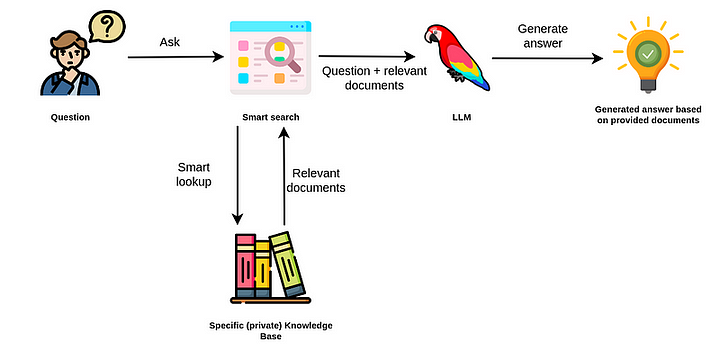

As mentioned, the RAG applications require a smart search tool that is able to retrieve additional information based on the user input, which allows the LLMs to produce more accurate and up-to-date answers. At first, the focus was mostly on retrieving information from unstructured text using semantic search. However, it soon became evident that a combination of structured and unstructured data is the best approach to RAG applications if you want to move beyond "Chat with your PDF" applications.

Neo4j was and is an excellent fit for handling structured information, but it struggled a bit with semantic search due to its brute-force approach. However, the struggle is in the past as Neo4j has introduced a new vector index in version 5.11 designed to efficiently perform semantic search over unstructured text or other embedded data modalities. The newly added vector index makes Neo4j a great fit for most RAG applications as it now works great with both structured and unstructured data.

In this blog post I will show you how to setup a vector index in Neo4j and integrate it into the LangChain ecosystem.

## Neo4j Environment setup

You need to setup a Neo4j 5.11 or greater to follow along with the examples in this blog post. The easiest way is to start a free instance on Neo4j Aura, which offers cloud instances of Neo4j database. Alternatively, you can also setup a local instance of the Neo4j database by downloading the Neo4j Desktop application and creating a local database instance.

After you have instantiated the Neo4j database, you can use the LangChain library to connect to it.

In [2]:
from langchain.graphs import Neo4jGraph

NEO4J_URI="neo4j+s://databases.neo4j.io"
NEO4J_USERNAME="neo4j"
NEO4J_PASSWORD="-"

graph = Neo4jGraph(
    url=NEO4J_URI,
    username=NEO4J_USERNAME,
    password=NEO4J_PASSWORD
)

## Setting up the Vector Index

Neo4j vector index is powered by Lucene, where Lucene implements a Hierarchical Navigable Small World (HNSW) Graph to perform a approximate nearest neighbors (ANN) query over the vector space.

Neo4j's implementation of the vector index is designed to index a single node property of a node label. For example, if you wanted to index nodes with the label Chunk on their node property embedding , you would use the following Cypher procedure.

In [3]:
graph.query("""
CALL db.index.vector.createNodeIndex(
  'wikipedia', // index name
  'Chunk',     // node label
  'embedding', // node property
   1536,       // vector size
   'cosine'    // similarity metric
)
""")

[]

Along with the index name, node label, and property, you must specify the vector size (embedding dimension), and the similarity metric. We will be using OpenAI's text-embedding-ada-002 embedding model, which uses vector size 1536 to represent text in the embedding space. At the moment, only the cosine and Euclidean similarity metrics are available. OpenAI suggests using the cosine similarity metric when using their embedding model.

## Populating the Vector index

Neo4j is schema-less by design, which means it doesn't enforce any restrictions what goes into a node property. For example, the embedding property of the Chunk node could store integers, list of integers or even strings. Let's try this out.

In [4]:
graph.query("""
WITH [1, [1,2,3], ["2","5"], [x in range(0, 1535) | toFloat(x)]] AS exampleValues
UNWIND range(0, size(exampleValues) - 1) as index
CREATE (:Chunk {embedding: exampleValues[index], index: index})
""")

[]

This query creates a Chunknode for each element in the list and uses the element as the embeddingproperty value. For example, the first Chunk node will have the embedding property value 1, the second node [1,2,3], and so on. Neo4j doesn't enforce any rules on what you can store under node properties. However, the vector index has clear instructions about the type of values and their embedding dimension it should index.
We can test which values were indexed by performing a vector index search.

In [5]:
graph.query("""
CALL db.index.vector.queryNodes(
  'wikipedia', // index name
  3, // topK neighbors to return
  [x in range(0,1535) | toFloat(x) / 2] //input vector
)
YIELD node, score
RETURN node.index AS index, score
""")

[{'index': 3, 'score': 1.0}]

If you run this query, you will get only a single node returned, even though you requested the top 3 neighbors to be returned. Why is that so? The vector index only indexes property values, where the value is a list of floats with the specified size. In this example, only one embeddingproperty value had the list of floats type with the selected length 1536.
A node is indexed by the vector index if all the following are true:
* The node contains the configured label.
* The node contains the configured property key.
* The respective property value is of type LIST<FLOAT>.
* The size() of the respective value is the same as the configured dimensionality.
* The value is a valid vector for the configured similarity function.

In [6]:
graph.query("""
MATCH (n) DETACH DELETE n
""")

[]

## Integrating the vector index into the LangChain ecosystem
Now we will implement a simple custom LangChain class that will use the Neo4j Vector index to retrieve relevant information to generate accurate and up-to-date answers. But first, we have to populate the vector index.

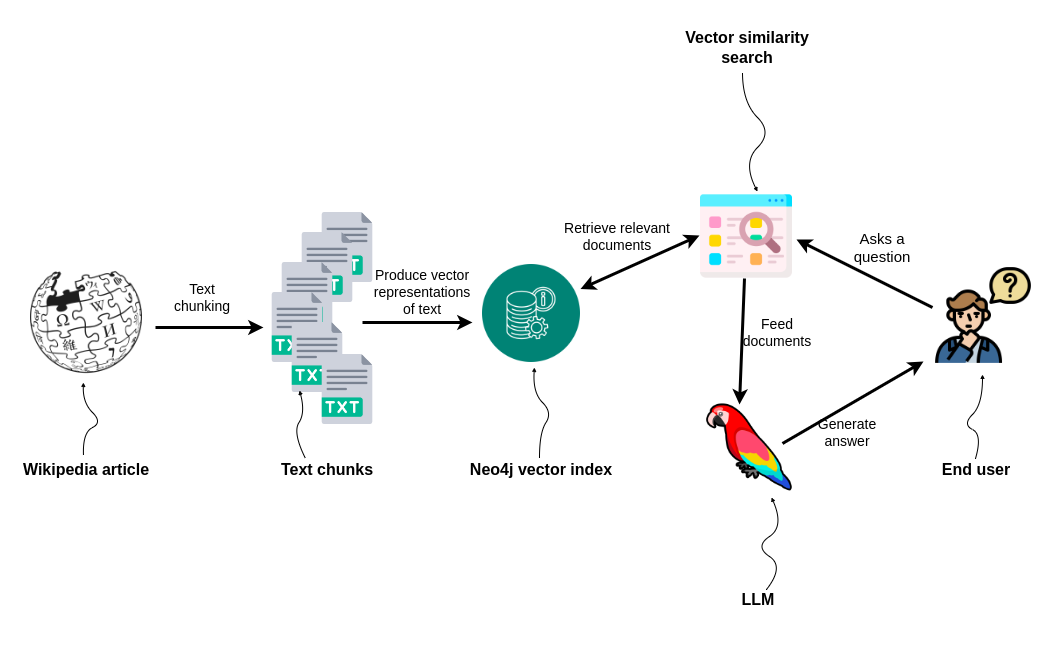

The task will consist of the following steps:
* Retrieve a Wikipedia article
* Chunk the text
* Store the text along with its vector representation in Neo4j
* Implement a custom LangChain class to support RAG applications

In this example, we will fetch only a single Wikipedia article. I have decided to use Baldur's Gate 3 page.

In [7]:
import wikipedia

bg3 = wikipedia.page(pageid=60979422)

In [8]:
print(bg3.content)

Baldur's Gate 3 is a role-playing video game developed and published by Larian Studios. It is the third main game in the Baldur's Gate series, which is based on the Dungeons & Dragons tabletop role-playing system. A partial version of the game was released in early access format for macOS, Windows, and the Stadia streaming service, on 6 October 2020. The game remained in early access until its full release on Windows on 3 August 2023. macOS and PlayStation 5 versions are scheduled for release on 6 September 2023. The Stadia version was cancelled following Stadia's closure.
Baldur's Gate 3 was acclaimed by critics, who praised the gameplay, narrative, amount of content, and player choice.


== Gameplay ==
Baldur's Gate 3 is a role-playing video game that offers both a single-player and cooperative multiplayer element. Players can create one or more characters and form a party along with a number of pre-generated characters to explore the game's story. Optionally, players are able to tak

Next, we need to chunk and embed the text. We will split the text by section using the double newline delimiter and then use OpenAI's embedding model to represent each section with an appropriate vector.

In [9]:
import os
from langchain.embeddings import OpenAIEmbeddings

os.environ["OPENAI_API_KEY"] = "OPENAI_API_KEY"

embeddings = OpenAIEmbeddings()

chunks = [{'text':el, 'embedding': embeddings.embed_query(el)} for
                  el in bg3.content.split("\n\n") if len(el) > 50]

Before we move on to the LangChain class, we need to import the text chunks into Neo4j.

In [10]:
graph.query("""
UNWIND $data AS row
CREATE (c:Chunk {text: row.text})
WITH c, row
CALL db.create.setVectorProperty(c, 'embedding', row.embedding)
YIELD node
RETURN distinct 'done'
""", {'data': chunks})

[{"'done'": 'done'}]

One thing you can notice is that I used the db.create.setVectorProperty procedure to store the vectors to Neo4j. This procedure is used to verify that the property value is indeed a list of floats. Additionally, it has the added benefit of reducing the storage space of vector property by approximately 50%. Therefore, it is recommended always to use this procedure to store vectors to Neo4j.

Now we can go and implement the custom LangChain class used to retrieve information from Neo4j vector index and use it to generate answers.

In [11]:
from langchain.chains.base import Chain
from langchain.chains.llm import LLMChain
from langchain.chat_models import ChatOpenAI
from langchain.chains.question_answering.stuff_prompt import CHAT_PROMPT
from langchain.callbacks.manager import CallbackManagerForChainRun

from typing import Any, Dict, List
from pydantic import Field

vector_search = """
WITH $embedding AS e
CALL db.index.vector.queryNodes('wikipedia',$k, e) yield node, score
RETURN node.text AS result
ORDER BY score DESC
LIMIT 3
"""

class Neo4jVectorChain(Chain):
    """Chain for question-answering against a neo4j vector index."""

    graph: Neo4jGraph = Field(exclude=True)
    input_key: str = "query"  #: :meta private:
    output_key: str = "result"  #: :meta private:
    embeddings: OpenAIEmbeddings = OpenAIEmbeddings()
    qa_chain: LLMChain = LLMChain(llm=ChatOpenAI(temperature=0), prompt=CHAT_PROMPT)

    @property
    def input_keys(self) -> List[str]:
        """Return the input keys.
        :meta private:
        """
        return [self.input_key]

    @property
    def output_keys(self) -> List[str]:
        """Return the output keys.
        :meta private:
        """
        _output_keys = [self.output_key]
        return _output_keys

    def _call(self, inputs: Dict[str, str], run_manager, k=3) -> Dict[str, Any]:
        """Embed a question and do vector search."""
        question = inputs[self.input_key]
        embedding = self.embeddings.embed_query(question)
        run_manager.on_text(
            "Vector search embeddings:", end="\n", verbose=self.verbose
        )
        run_manager.on_text(
            embedding[:5], color="green", end="\n", verbose=self.verbose
        )

        context = self.graph.query(
            vector_search, {'embedding': embedding, 'k': 3})
        context = [el['result'] for el in context]
        run_manager.on_text(
            "Retrieved context:", end="\n", verbose=self.verbose
        )
        run_manager.on_text(
            context, color="green", end="\n", verbose=self.verbose
        )

        result = self.qa_chain(
            {"question": question, "context": context},
        )
        final_result = result[self.qa_chain.output_key]
        return {self.output_key: final_result}

I have omitted some boilerplate code to make it more readable. Essentially, when you can call the Neo4jVectorChain, the following steps are executed:
1. Embed the question using the relevant embedding model
2. Use the text embedding value to retrieve most similar content from the vector index
3. Use the provided context from similar content to generate the answer

We can now test our implementation.

In [12]:
vector_qa = Neo4jVectorChain(graph=graph, embeddings=embeddings, verbose=True)

In [13]:
vector_qa.run("What is the gameplay of Baldur's Gate 3 like?")



> Entering new Neo4jVectorChain chain...
Vector search embeddings:
[0.001163442909793317, -0.03362896087993143, -0.008195404370601279, -0.002520517105697522, 0.0013487993944175268]
Retrieved context:
["\n== Gameplay ==\nBaldur's Gate 3 is a role-playing video game that offers both a single-player and cooperative multiplayer element. Players can create one or more characters and form a party along with a number of pre-generated characters to explore the game's story. Optionally, players are able to take one of their characters and team up online with other players to form a party. Like previous games in the Baldur's Gate series, Baldur's Gate 3 has turn-based combat, similar to Larian's earlier games Divinity: Original Sin and Divinity: Original Sin II; all combat is based on the D&D 5th Edition rules.", "Baldur's Gate 3 is a role-playing video game developed and published by Larian Studios. It is the third main game in the Baldur's Gate series, which is based on the Dungeons & Dragon

"The gameplay of Baldur's Gate 3 is a role-playing video game that offers both a single-player and cooperative multiplayer element. Players can create one or more characters and form a party along with pre-generated characters to explore the game's story. The game features turn-based combat, similar to Larian's earlier games Divinity: Original Sin and Divinity: Original Sin II, and all combat is based on the D&D 5th Edition rules."

## Summary
Leveraging Neo4j's new vector indexing capabilities, you can create a unified data source that powers Retrieval Augmented Generation applications effectively. This allows you to not only implement "Chat with your PDF or documentation" solutions but also to conduct real-time analytics, all from a single, robust data source. This multi-purpose utility can streamline your operations and enhances data synergy, making Neo4j a great solution for managing both structured and unstructured data.